Fetch data (~52MB) from gdrive

In [1]:
!bash -c '[[ -f experimental_data.json ]] || gdown --fuzzy https://drive.google.com/file/d/1GJ7E6QGOFCL1VOHkCyOUftks9DBC-E3I/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1GJ7E6QGOFCL1VOHkCyOUftks9DBC-E3I
To: /home/leonhard/projects/tuplex-public/experimental/notebooks/experiment_result.json
100%|██████████████████████████████████████| 55.1M/55.1M [00:05<00:00, 10.7MB/s]


In [15]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.lines import Line2D

In [16]:
with open('experiment_result.json', 'r') as fp:
    data = fp.read()

In [17]:
lines = data.strip().split('\n')
len(lines)

22

In [18]:
d = [json.loads(line) for line in lines]
df = pd.DataFrame(d)

In [19]:
#df = pd.read_json('experimental_data.json', lines=True)
#df = pd.read_json('data_first8mb_sampled.json', lines=True)
# df = pd.read_json('data_first256K_sampled.json', lines=True)

In [20]:
df.columns

Index(['buf_size_compressed', 'buf_size_uncompressed', 'fallback_mem',
       'fallback_rows', 'general_case', 'general_case_field_count',
       'general_json_paths', 'general_mem', 'general_rows', 'mode',
       'normal_case', 'normal_case_field_count', 'normal_json_paths',
       'normal_mem', 'normal_rows', 'path', 'perfect_sample',
       'sample_row_count', 'sample_size', 'total_rows', 'type_counts'],
      dtype='object')

In [21]:
df['year'] = df['path'].apply(lambda x: x.replace('.json.gz', '')).apply(lambda x: x[x.rfind('/')+1:].split('-')[0]).astype(int)

In [22]:
df[df['mode'] == 'hyper'].sort_values(by=['year'])['total_rows']

10      48899
9      165692
8      296456
7      476393
6      737714
5      678134
4      910100
3     1522655
2     2134789
1     2963694
0     1078139
Name: total_rows, dtype: int64

In [23]:
df[df['mode'] == 'global'].sort_values(by=['year'])['total_rows']

21      48899
20     165692
19     296456
18     476393
17     737714
16     678134
15     910100
14    1522655
13    2134789
12    2963694
11    1078139
Name: total_rows, dtype: int64

sanity check done, now let's plot them next to each other

In [24]:
df_hyper = df[df['mode'] == 'hyper'].sort_values(by=['year'])
df_global = df[df['mode'] == 'global'].sort_values(by=['year'])

plot nice overview over data

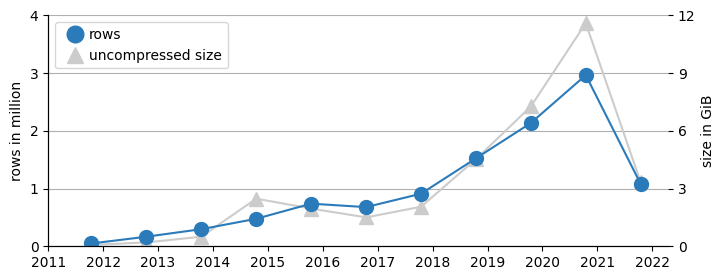

In [33]:
plt.figure(figsize=(8, 3))

primary_col = sns.color_palette('Blues')[-2]
secondary_col = [0.8]*3


ax1 = plt.gca()
xq = np.arange(len(df_global))
oct_offset = 288/365 # ignore leap year
ax1.plot(xq + oct_offset, df_global['total_rows'] / 10**6, marker='o', color=primary_col, markersize=10)

ax1.set_ylabel('rows in million')
ax1.set_ylim(0, 4)
xt = np.array([0, 1, 2, 3, 4])
ax1.set_yticks(xt)
ax2 = ax1.twinx()
ax2.plot(xq + oct_offset, df_global['buf_size_uncompressed'] / (1024**3), color=secondary_col, marker='^', markersize=10)
ax2.set_ylim(0, 12)
ax2.set_yticks(xt * 3)
ax2.set_ylabel('size in GiB')

# fix for ordering
ax2.zorder=0
ax1.zorder=1
ax1.patch.set_visible(False)

lgd_handles = []
lgd_handles.append(Line2D([0], [0], marker='o', color=primary_col, label='rows',
                    markerfacecolor=primary_col, markersize=12, linewidth=0))
lgd_handles.append(Line2D([0], [0], marker='^', color=secondary_col, label='uncompressed size',
                    markerfacecolor=secondary_col, markersize=12, linewidth=0))
ax = plt.gca()
ax.legend(handles=lgd_handles, fontsize=10, handletextpad=0.05)

sns.despine()
xq = np.arange(len(df_global) + 1)
plt.xticks(xq, list(df_global['year'].values) + ['2022'])
plt.grid(axis='y')

plt.savefig('peryear_data_overview.pdf', transparent=True, bbox_inches = 'tight', pad_inches = 0)


In [ ]:
def plot_bars(subdf, xoff, w, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_rows'],  w, color=c1)
    plt.bar(xq + xoff, subdf['general_rows'], w, bottom=subdf['normal_rows'], color=c2)
    plt.bar(xq + xoff, subdf['fallback_rows'], w, bottom=subdf['normal_rows'] + subdf['general_rows'], color=c3)
    
def plot_bars_mem(subdf, xoff, w, mem_factor, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_mem'] / mem_factor,  w, color=c1)
    plt.bar(xq + xoff, subdf['general_mem'] / mem_factor, w, bottom=subdf['normal_mem'] / mem_factor, color=c2)
    plt.bar(xq + xoff, subdf['fallback_mem'] / mem_factor, w, bottom=subdf['normal_mem']  / mem_factor + subdf['general_mem']  / mem_factor, color=c3)

In [ ]:
plt.figure(figsize=(10, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Blues', 3)[::-1]
plot_bars(df_hyper, -.2, 0.4, c1, c2 , c3)
normal = df_hyper['normal_rows'].sum()
general = df_hyper['general_rows'].sum()
fallback = df_hyper['fallback_rows'].sum()
handles += [(f'hyper (normal)    {normal:,} rows', c1),
            (f'hyper (general)   {general:,} rows', c2),
            (f'hyper (fallback)    {fallback:,} rows', c3)]
c1, c2, c3 = sns.color_palette('Reds', 3)[::-1]
normal =   df_global['normal_rows'].sum()
general =  df_global['general_rows'].sum()
fallback = df_global['fallback_rows'].sum()
handles += [(f'global (normal)    {normal:,} rows', c1),
            (f'global (general)    {general:,} rows', c2),
            (f'global (fallback)   {fallback:,} rows', c3)]
plot_bars(df_global, .2, 0.4, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel('#rows')
plt.xlabel('year')

from matplotlib.lines import Line2D

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(handles=lgd_handles, fontsize=10, handletextpad=0.05)

In [ ]:
# require filter promotion etc. to get a better fit? E.g., a restrictive filter on years 2015 and 2016 could do.

In [ ]:
plt.figure(figsize=(10, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Greens', 3)[::-1]
mem_factor = 1024 * 1024
mem_unit = 'MiB'
plot_bars_mem(df_hyper, -.2, 0.4, mem_factor, c1, c2 , c3)
normal = int(df_hyper['normal_mem'].sum() / mem_factor)
general = int(df_hyper['general_mem'].sum() / mem_factor)
fallback = int(df_hyper['fallback_mem'].sum() / mem_factor)
handles += [(f'hyper (normal)    {normal:,} {mem_unit}', c1),
            (f'hyper (general)   {general:,} {mem_unit}', c2),
            (f'hyper (fallback)  {fallback:,} {mem_unit}', c3)]
c1, c2, c3 = sns.color_palette('Greys', 3)[::-1]
normal =   int(df_global['normal_mem'].sum() / mem_factor)
general =  int(df_global['general_mem'].sum() / mem_factor)
fallback = int(df_global['fallback_mem'].sum() / mem_factor)
handles += [(f'global (normal)    {normal:,} {mem_unit}', c1),
            (f'global (general)     {general:,} {mem_unit}', c2),
            (f'global (fallback) {fallback:,} {mem_unit}', c3)]
plot_bars_mem(df_global, .2, 0.4, mem_factor, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(handles=lgd_handles, fontsize=10, handletextpad=0.05)

In [ ]:
# interpolation for full dataset (pretty off)
hyper_total = df_hyper['normal_mem'].sum() + df_hyper['general_mem'].sum() + df_hyper['fallback_mem'].sum()
global_total = df_global['normal_mem'].sum() + df_global['general_mem'].sum() + df_global['fallback_mem'].sum()

print('memory usage:: hyper {:.1f} MiB  global {:.1f} MiB'.format(
    hyper_total / mem_factor, global_total / mem_factor))

In [ ]:
# averages per row may be also interesting:

print('encoding 1 row in normal   (hyper): {:.2f} Kib'.format(
    df_hyper['normal_mem'].sum() / df_hyper['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (hyper): {:.2f} Kib'.format(
    df_hyper['general_mem'].sum() / df_hyper['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (hyper): {:.2f} Kib'.format(
    df_hyper['fallback_mem'].sum() / df_hyper['fallback_rows'].sum() / 1024))
print('----')
print('encoding 1 row in normal   (global): {:.2f} Kib'.format(
    df_global['normal_mem'].sum() / df_global['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (global): {:.2f} Kib'.format(
    df_global['general_mem'].sum() / df_global['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (global): {:.2f} Kib'.format(
    df_global['fallback_mem'].sum() / df_global['fallback_rows'].sum() / 1024))

In [ ]:
plt.plot(df_hyper['buf_size_compressed'] / mem_factor, 'o', label='compressed data size')
plt.plot(df_hyper['buf_size_uncompressed'] / mem_factor, 'o', label='compressed data size')
plt.xticks(xq, df_hyper['year'])
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.legend(loc='best')

In [ ]:
# least complex normal-case
sorted(list(df['normal_case'].values), key=len)[0]

In [ ]:
# most complex normal-case
sorted(list(df['normal_case'].values), key=len)[-1]

In [ ]:
# least complex general_case
sorted(list(df['general_case'].values), key=len)[0]

In [ ]:
# most complex general_case
sorted(list(df['general_case'].values), key=len)[-1]

In [ ]:
df_global['normal_case'].iloc[0]

In [ ]:
df_global['general_case'].iloc[0]

In [ ]:
df_hyper['total_rows']

In [ ]:
# -> prob. picks up the wrong normal-case/global case... -> selection routine may be off...

Improvements:
    
    - pick specific day (October 15th :P?)
    - combine data for the day (so it's larger)
    - rerun this experiment

Observations: 

    -> why is there nearly no general-case matching in the global specialization case?

--> perform pushdown (PushEvent?)

--> then map function

Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'=>str),(str,'id'=>i64),(str,'login'=>str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'=>str),(str,'org'=>Struct[(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'_links'=>Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'pull_request'->Struct[(str,'href'->str)])]),(str,'author_association'=>str),(str,'body'->str),(str,'commit_id'=>str),(str,'created_at'->str),(str,'diff_hunk'=>str),(str,'html_url'=>str),(str,'id'->i64),(str,'issue_url'=>str),(str,'line'=>Option[i64]),(str,'node_id'=>str),(str,'original_commit_id'=>str),(str,'original_position'=>i64),(str,'path'=>Option[str]),(str,'performed_via_github_app'=>null),(str,'position'=>Option[i64]),(str,'pull_request_url'=>str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)])]),(str,'commits'=>List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'=>boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'desc'=>str),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'download'=>Struct[(str,'created_at'->str),(str,'content_type'->str),(str,'name'->str),(str,'id'->i64),(str,'description'->str),(str,'html_url'->str),(str,'size'->i64),(str,'url'->str),(str,'download_count'->i64)]),(str,'forkee'=>Struct[(str,'archive_url'=>str),(str,'archived'=>boolean),(str,'assignees_url'=>str),(str,'blobs_url'=>str),(str,'branches_url'=>str),(str,'clone_url'->str),(str,'collaborators_url'=>str),(str,'comments_url'=>str),(str,'commits_url'=>str),(str,'compare_url'=>str),(str,'contents_url'=>str),(str,'contributors_url'=>str),(str,'created_at'->str),(str,'default_branch'=>str),(str,'deployments_url'=>str),(str,'description'->Option[str]),(str,'disabled'=>boolean),(str,'downloads_url'=>str),(str,'events_url'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'=>i64),(str,'forks_url'=>str),(str,'full_name'=>str),(str,'git_commits_url'=>str),(str,'git_refs_url'=>str),(str,'git_tags_url'=>str),(str,'git_url'->str),(str,'has_downloads'=>boolean),(str,'has_issues'=>boolean),(str,'has_pages'=>boolean),(str,'has_projects'=>boolean),(str,'has_wiki'=>boolean),(str,'homepage'->Option[str]),(str,'hooks_url'=>str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'=>str),(str,'issue_events_url'=>str),(str,'issues_url'=>str),(str,'keys_url'=>str),(str,'labels_url'=>str),(str,'language'->Option[str]),(str,'languages_url'=>str),(str,'license'=>Option[Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]]),(str,'master_branch'=>null),(str,'merges_url'=>str),(str,'milestones_url'=>str),(str,'mirror_url'=>null),(str,'name'->str),(str,'node_id'=>str),(str,'notifications_url'=>str),(str,'open_issues'->i64),(str,'open_issues_count'=>i64),(str,'owner'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)]),(str,'private'->boolean),(str,'public'->boolean),(str,'pulls_url'=>str),(str,'pushed_at'->str),(str,'releases_url'=>str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'=>i64),(str,'stargazers_url'=>str),(str,'statuses_url'=>str),(str,'subscribers_url'=>str),(str,'subscription_url'=>str),(str,'svn_url'->str),(str,'tags_url'=>str),(str,'teams_url'=>str),(str,'trees_url'=>str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'=>i64)]),(str,'gist'=>Struct[(str,'comments'->i64),(str,'created_at'->str),(str,'description'->str),(str,'files'->{}),(str,'git_pull_url'->str),(str,'git_push_url'->str),(str,'html_url'->str),(str,'id'->str),(str,'public'->boolean),(str,'updated_at'->str),(str,'url'->str),(str,'user'->null)]),(str,'head'=>str),(str,'id'=>i64),(str,'issue'=>Struct[(str,'active_lock_reason'=>null),(str,'assignee'->Option[Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]]),(str,'assignees'=>[]),(str,'author_association'=>str),(str,'body'->Option[str]),(str,'closed_at'->Option[str]),(str,'comments'->i64),(str,'comments_url'=>str),(str,'created_at'->str),(str,'events_url'=>str),(str,'html_url'->str),(str,'id'->i64),(str,'labels'->[]),(str,'labels_url'=>str),(str,'locked'=>boolean),(str,'milestone'->null),(str,'node_id'=>str),(str,'number'->i64),(str,'performed_via_github_app'=>null),(str,'pull_request'=>Struct[(str,'diff_url'->Option[str]),(str,'html_url'->Option[str]),(str,'patch_url'->Option[str]),(str,'url'=>str)]),(str,'repository_url'=>str),(str,'state'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)])]),(str,'master_branch'=>str),(str,'member'=>Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)]),(str,'name'=>str),(str,'number'=>i64),(str,'pages'=>List[Struct[(str,'action'->str),(str,'html_url'->str),(str,'page_name'->str),(str,'sha'->str),(str,'summary'->null),(str,'title'->str)]]),(str,'pull_request'=>Struct[(str,'_links'->Struct[(str,'comments'->Struct[(str,'href'->str)]),(str,'commits'=>Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'=>Struct[(str,'href'->str)]),(str,'review_comment'=>Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'self'->Struct[(str,'href'->str)]),(str,'statuses'=>Struct[(str,'href'->str)])]),(str,'active_lock_reason'=>null),(str,'additions'=>i64),(str,'assignee'=>null),(str,'assignees'=>[]),(str,'author_association'=>str),(str,'auto_merge'=>null),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'=>str),(str,'archived'=>boolean),(str,'assignees_url'=>str),(str,'blobs_url'=>str),(str,'branches_url'=>str),(str,'clone_url'->str),(str,'collaborators_url'=>str),(str,'comments_url'=>str),(str,'commits_url'=>str),(str,'compare_url'=>str),(str,'contents_url'=>str),(str,'contributors_url'=>str),(str,'created_at'->str),(str,'default_branch'=>str),(str,'deployments_url'=>str),(str,'description'->Option[str]),(str,'disabled'=>boolean),(str,'downloads_url'=>str),(str,'events_url'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'=>i64),(str,'forks_url'=>str),(str,'full_name'=>str),(str,'git_commits_url'=>str),(str,'git_refs_url'=>str),(str,'git_tags_url'=>str),(str,'git_url'->str),(str,'has_downloads'=>boolean),(str,'has_issues'=>boolean),(str,'has_pages'=>boolean),(str,'has_projects'=>boolean),(str,'has_wiki'=>boolean),(str,'homepage'->Option[str]),(str,'hooks_url'=>str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'=>str),(str,'issue_events_url'=>str),(str,'issues_url'=>str),(str,'keys_url'=>str),(str,'labels_url'=>str),(str,'language'->Option[str]),(str,'languages_url'=>str),(str,'license'=>Option[Struct[(str,'key'->str),(str,'name'->str),(str,'node_id'->str),(str,'spdx_id'->str),(str,'url'->Option[str])]]),(str,'master_branch'=>null),(str,'merges_url'=>str),(str,'milestones_url'=>str),(str,'mirror_url'=>null),(str,'name'->str),(str,'node_id'=>str),(str,'notifications_url'=>str),(str,'open_issues'->i64),(str,'open_issues_count'=>i64),(str,'owner'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)]),(str,'private'->boolean),(str,'pulls_url'=>str),(str,'pushed_at'->str),(str,'releases_url'=>str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'=>i64),(str,'stargazers_url'=>str),(str,'statuses_url'=>str),(str,'subscribers_url'=>str),(str,'subscription_url'=>str),(str,'svn_url'->str),(str,'tags_url'=>str),(str,'teams_url'=>str),(str,'trees_url'=>str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'=>i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)])]),(str,'body'->Option[str]),(str,'changed_files'=>i64),(str,'closed_at'->Option[str]),(str,'comments'=>i64),(str,'comments_url'=>str),(str,'commits'=>i64),(str,'commits_url'=>str),(str,'created_at'->str),(str,'deletions'=>i64),(str,'diff_url'->str),(str,'draft'=>boolean),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'=>str),(str,'archived'=>boolean),(str,'assignees_url'=>str),(str,'blobs_url'=>str),(str,'branches_url'=>str),(str,'clone_url'->str),(str,'collaborators_url'=>str),(str,'comments_url'=>str),(str,'commits_url'=>str),(str,'compare_url'=>str),(str,'contents_url'=>str),(str,'contributors_url'=>str),(str,'created_at'->str),(str,'default_branch'=>str),(str,'deployments_url'=>str),(str,'description'->Option[str]),(str,'disabled'=>boolean),(str,'downloads_url'=>str),(str,'events_url'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'=>i64),(str,'forks_url'=>str),(str,'full_name'=>str),(str,'git_commits_url'=>str),(str,'git_refs_url'=>str),(str,'git_tags_url'=>str),(str,'git_url'->str),(str,'has_downloads'=>boolean),(str,'has_issues'=>boolean),(str,'has_pages'=>boolean),(str,'has_projects'=>boolean),(str,'has_wiki'=>boolean),(str,'homepage'->Option[str]),(str,'hooks_url'=>str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'=>str),(str,'issue_events_url'=>str),(str,'issues_url'=>str),(str,'keys_url'=>str),(str,'labels_url'=>str),(str,'language'->Option[str]),(str,'languages_url'=>str),(str,'license'=>Option[Struct[(str,'key'->str),(str,'name'->str),(str,'node_id'->str),(str,'spdx_id'->str),(str,'url'->Option[str])]]),(str,'master_branch'=>null),(str,'merges_url'=>str),(str,'milestones_url'=>str),(str,'mirror_url'=>null),(str,'name'->str),(str,'node_id'=>str),(str,'notifications_url'=>str),(str,'open_issues'->i64),(str,'open_issues_count'=>i64),(str,'owner'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)]),(str,'private'->boolean),(str,'pulls_url'=>str),(str,'pushed_at'->str),(str,'releases_url'=>str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'=>i64),(str,'stargazers_url'=>str),(str,'statuses_url'=>str),(str,'subscribers_url'=>str),(str,'subscription_url'=>str),(str,'svn_url'->str),(str,'tags_url'=>str),(str,'teams_url'=>str),(str,'trees_url'=>str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'=>i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)])]),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'->str),(str,'labels'=>[]),(str,'locked'=>boolean),(str,'maintainer_can_modify'=>boolean),(str,'merge_commit_sha'=>Option[str]),(str,'mergeable'=>null),(str,'mergeable_state'=>str),(str,'merged'=>boolean),(str,'merged_at'->Option[str]),(str,'merged_by'=>Option[Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)]]),(str,'milestone'=>null),(str,'node_id'=>str),(str,'number'->i64),(str,'patch_url'->str),(str,'rebaseable'=>null),(str,'requested_reviewers'=>[]),(str,'requested_teams'=>[]),(str,'review_comment_url'=>str),(str,'review_comments'=>i64),(str,'review_comments_url'=>str),(str,'state'->str),(str,'statuses_url'=>str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'avatar_url'->str),(str,'events_url'=>str),(str,'followers_url'=>str),(str,'following_url'=>str),(str,'gists_url'=>str),(str,'gravatar_id'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'login'->str),(str,'node_id'=>str),(str,'organizations_url'=>str),(str,'received_events_url'=>str),(str,'repos_url'=>str),(str,'site_admin'=>boolean),(str,'starred_url'=>str),(str,'subscriptions_url'=>str),(str,'type'=>str),(str,'url'->str)])]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'release'=>Struct[(str,'assets'->[]),(str,'assets_url'->str),(str,'author'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str),(str,'created_at'->str),(str,'draft'->boolean),(str,'html_url'->str),(str,'id'->i64),(str,'is_short_description_html_truncated'=>boolean),(str,'name'->str),(str,'node_id'->str),(str,'prerelease'->boolean),(str,'published_at'->str),(str,'short_description_html'=>null),(str,'tag_name'->str),(str,'tarball_url'->str),(str,'target_commitish'->str),(str,'upload_url'->str),(str,'url'->str),(str,'zipball_url'->str)]),(str,'review'=>Struct[(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str),(str,'commit_id'->str),(str,'submitted_at'->str),(str,'state'->str),(str,'html_url'->str),(str,'pull_request_url'->str),(str,'author_association'->str),(str,'_links'->Struct[(str,'html'->Struct[(str,'href'->str)]),(str,'pull_request'->Struct[(str,'href'->str)])])]),(str,'size'=>i64),(str,'target'=>Struct[(str,'avatar_url'->str),(str,'bio'->Option[str]),(str,'blog'->Option[str]),(str,'company'->Option[str]),(str,'created_at'->str),(str,'email'->Option[str]),(str,'followers'->i64),(str,'following'->i64),(str,'gravatar_id'->str),(str,'hireable'->boolean),(str,'html_url'->str),(str,'id'->i64),(str,'location'->Option[str]),(str,'login'->str),(str,'name'->str),(str,'public_gists'->i64),(str,'public_repos'->i64),(str,'type'->str),(str,'url'->str)]),(str,'url'=>str)]),(str,'public'->boolean),(str,'repo'=>Struct[(str,'id'=>i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str),(str,'url'=>str)]